<img src="https://drive.google.com/uc?id=1dtR470-kr9MhA_vytTgnLtdrr5X7HaXu" width="150"/>

### Name: [*Sijia Chen*]
### CID: [*02090792*]

In [1]:
!pip install pycm livelossplot
!pip install prettytable
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Instructions:

Follow the instructions below to complete the coursework and submit it:

1. Read the materials you will need to complete the coursework; you can find them in the github classroom repo provided together with this notebook. The provided materials are: 

  - The paper [*Gradient based learning applied to document recognition*](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) by Yann LeCunn where he describes the original form of the LeNet-5 architecture.

  - The paper [*Visualizing the Loss Landscape of Neural Nets*](https://arxiv.org/pdf/1712.09913.pdf).

  - This Jupyter Notebook template to fill in your answers (it contains some code to assist you).


2. Complete your coursework using this provided Jupyter Notebook template (use Google Colab or your local machine if it has a GPU and/or sufficient computational power).

3. Once you have completed your answers, upload your final notebook to the repo you got from the github classroom link (as you normally do). Make sure to have all the answers in there:

   - **All the cells in your final Jupyter Notebook should be executed before saving and uploading to github in order to have the output of the cells available in the uploaded version** (images you plot, training graphs generated with `livelossplot`, etc). We will not guarantee that if some code blocks are missing we will be able to rerun them for you.

   - Add comments in the code to explain what you are doing at every step. 

   - All answers requiring written answers (ie, not code) should be in markdown blocks in the Jupyter Notebook. This provided Jupyter Notebook template has allocated blocks for the questions, but you can add any coding or markdown blocks that you need.

4. The coursework is released on **Friday 13 May at 15:30h BST**, and the answers have to be submitted on **Saturday  21 May, 23:59h BST**. We will not accept late submissions.

    ***[BST stands for British Summer Time (local UK time)]***

<br>

---
<br>

### The coursework consists of a number of questions/exercises you have to complete. You will find them below.

## Imports

In [2]:
# your imports and initial checks here
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from livelossplot import PlotLosses
from sklearn.model_selection import StratifiedShuffleSplit

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## 1-Load the medical MNIST dataset [10 points]
Go to this [kaggle dataset](https://www.kaggle.com/datasets/andrewmvd/medical-mnist/code) and download the data (see provided snippets below).

Format the data as you see fit to use it in your next questions. Explain the process you follow.

[**It is recommended that you convert the images to grayscale using** *torchvision transforms*]

Use the following snippets of code to help you download the data first:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
# Get kaggle authentication json
! mkdir ~/.kaggle
! cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/
! ls ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

kaggle.json


In [5]:
# Download and unzip dataset
! kaggle datasets download -d andrewmvd/medical-mnist
! mkdir ./medical-mnist
! unzip -q ./medical-mnist.zip -d medical-mnist

 80% 68.0M/84.8M [00:00<00:00, 257MB/s]
100% 84.8M/84.8M [00:00<00:00, 250MB/s]


Use ImageFolder to create a dataset and load the download data in it. Convert the images to grayscale to make the dataset in a single channel that we can process data easier.

In [6]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(1)
    ])

medical_MNIST = datasets.ImageFolder("./medical-mnist", transform = transform)
print(medical_MNIST)

Dataset ImageFolder
    Number of datapoints: 58954
    Root location: ./medical-mnist
    StandardTransform
Transform: Compose(
               ToTensor()
               Grayscale(num_output_channels=1)
           )


## 2-Plot data [5 points]
Plot 25 images of the training set together with their corresponding label names.






In [ ]:
# your code goes here
def show_batch(dataset, nr=4, nc=4):
  fig, axarr = plt.subplots(nr, nc, figsize=(10, 10))
  for i in range(nr):
      for j in range(nc):
          idx = random.randint(0, len(medical_MNIST))
          sample, target = medical_MNIST[idx]
          try:
            axarr[i][j].imshow(sample, cmap='bone') # if PIL
          except:
            axarr[i][j].imshow(sample.squeeze(0), cmap='bone') # compressed into one dimension and make sure the figures are in gray
          target_name = medical_MNIST.classes[target]
          axarr[i][j].set_title("%s (%i)"%(target_name, target))

  fig.tight_layout(pad=1.5)
  plt.show()

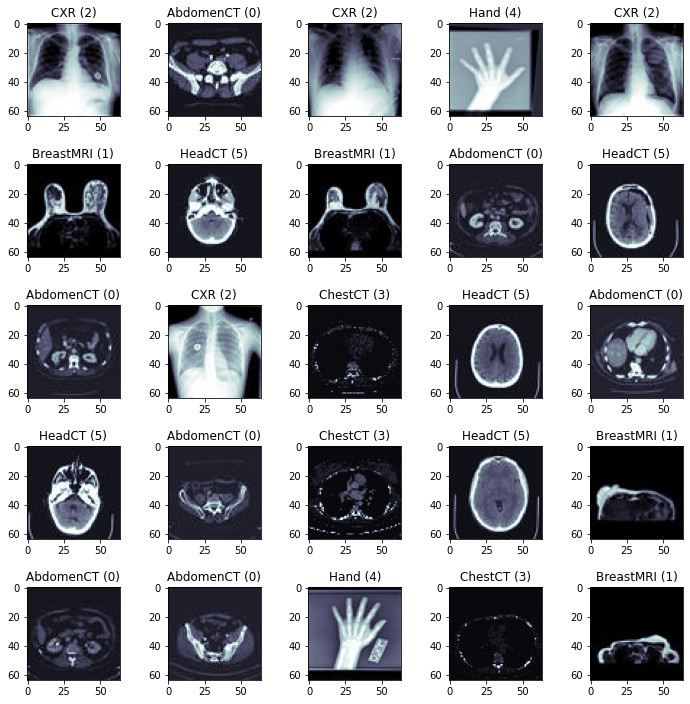

In [ ]:
# set a figure with 25 subplots as required.
show_batch(medical_MNIST, 5, 5)

## 3-Prepare your LeNet-5 network [10 points]
Use the code provided in the Jupyter Notebook template and modify it as you see fit to be able to perform a forward pass using a single dummy tensor input **x**.

Do you need to modify the size of any layers of the network for the Medical MNIST dataset? If yes, explain how you did it and implement the changes.

The lines of code that will do the forward pass and print the network are provided in the template.

## **The Answer is:**

In [ ]:
# view one image shape of the dataset.
img, label = medical_MNIST[0]
print(img.shape)

torch.Size([1, 64, 64])


- The network should have input's of size 64x64.  
- All convolutional layers with trainable parameters should have::
  - kernel-size=5
  - stride 1
  - no padding.
- All MaxPool layers use a kernel size 2 and a stride value of 2.
- Use ReLUs for all activations.
- Default in most layers in PyTorch is to include bias terms.

We can calculate the size of the layer with the equation: $$(\frac{n+2p-f}{s} +1) \times (\frac{n+2p-f}{s} +1)$$  where $n \times n$ is the image size, $f$ is the kernel(filter) size, $p$ is the padding value, $s$ is  the stride value.

Therefore, the size of each layer is:
- c1: 60x60
- s2: 30x30
- c3: 26x26
- s4: 13x13

In this case, c5 shoule be 

```
self.c5 = nn.Linear(16*13*13, 120) 
```

This method let the model has large trainable parameters but the images can keep as original as much as possible without loss of information.


In [7]:
# make modifications in the code below

class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1) 
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)   
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)   
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*13*13, 120)    
    self.f6 = nn.Linear(120, 84)   
    self.output = nn.Linear(84, 6)  # we have 6 classes in the dataset
    self.act = nn.ReLU()           
    
  def forward(self, x):
    x = self.act(self.c1(x))    
    x = self.act(self.s2(x))   
    x = self.act(self.c3(x))   
    x = self.act(self.s4(x))    
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))     
    x = self.act(self.c5(x))       
    x = self.act(self.f6(x))    
    return self.output(x)          

# Dummy input of the same size as the Medical-MNIST images
## generate a dummy tensor x
## get an instance of your model and call it model
x = torch.randn((1, 1, 64, 64))
model = LeNet5()
y = model(x) # if you have called your instance something different than model, modify this line of code
print(model)
print(x.shape, y.shape)

LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=2704, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=6, bias=True)
  (act): ReLU()
)
torch.Size([1, 1, 64, 64]) torch.Size([1, 6])


## 4-Create a training, validation split [5 points]
Split the data using `sklearn.model_selection.StratifiedShuffleSplit`:

- 90\% of the data in the training set
- 10\% of the data in the validation set

Verify the stratified shuffle split by plotting a histogram of the classes in the training and validation set.

Prepare the downloaded datasets to be used with your modified network from the previous section.

## The Answer is：

In [ ]:
# view the classes of the data
print(medical_MNIST.classes)

['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


In [15]:
# Get mean and std
tmp_loader = DataLoader(medical_MNIST, batch_size=len(medical_MNIST), num_workers=0)
ds, labels = next(iter(tmp_loader))

mean = torch.mean(ds.flatten()).item()
std = torch.std(ds.flatten()).item()
dmax = torch.max(ds.flatten()).item()

print(mean, std, dmax)

0.35831180214881897 0.2821691632270813 0.9999000430107117


In [16]:
def apply_standardization(X):
  X /= dmax
  X -= mean
  X /= std
  return X

In [17]:
# split the data
# set test_size=0.1 for 90:10 ratio of training and validation dataset
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(ds, labels) # create a shuffler
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0] # extract indices

In [18]:
indices

(array([43351, 57008, 23795, ..., 44868, 27269, 37822]),
 array([19931, 32660, 26809, ..., 54802, 44443, 43911]))

Then, count the number of training and validation set in each class.

In [19]:
train_num = []
valid_num = []
classes = medical_MNIST.classes #['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

# use labels to count the number of each group for training and validation dataset
for i in range(6):
  train_num.append(np.sum(np.array(labels)[indices[0]] == i))
  valid_num.append(np.sum(np.array(labels)[indices[1]] == i))

In [20]:
print(train_num)
print(valid_num)

[9000, 8058, 9000, 9000, 9000, 9000]
[1000, 896, 1000, 1000, 1000, 1000]


,train,valid
0,9000,1000
1,8058,896
2,9000,1000
3,9000,1000
4,9000,1000
5,9000,1000


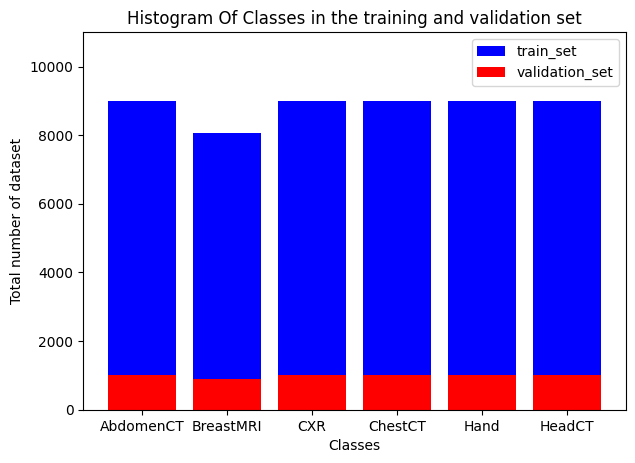

In [21]:
from torch._C import NumberType
from pandas.core.arrays.numeric import NumericArray
# create a dataframe which consists of numbers of training and validation data for each class
import pandas as pd
num = pd.DataFrame({'train':train_num, 'valid':valid_num})

fig, ax = plt.subplots(figsize=(7,5), dpi=100)
plt.bar(classes, height = num.train, color = 'Blue')
plt.bar(classes, height = num.valid, color = 'Red')
ax.set_title('Histogram Of Classes in the training and validation set')
ax.set_ylabel('Total number of dataset')
ax.set_xlabel('Classes')
plt.legend(['train_set', 'validation_set'], loc='upper right', fontsize=10)
plt.ylim(0,11000)
num

Data have been splited into training and validation sets with ratio of 9:1.

## 5-Grid search [20 points]
From  the  list  below,  select  two  hyperparameters  and  perform  a  2D  grid-search  to  find  the  optimal values for these two hyperparameters.  The range of values to test are provided.  Justify your choice of the two hyperparameters you want to tune (write a paragraph in a markdown cell explaining why you chose these two particular parameters). 

The list of hyperparameters to choose from is:

a)  Random Number Seed:  **42**  [31, 42, 53] \
b)  Learning Rate:  **1e-2**  [1e-1, 1e-2, 1e-3] \
c)  Momentum:  **0.5**  [0.2, 0.5, 0.8] \
d)  Batch Size:  **64**  [64, 128, 512] \
e)  Number of epochs:  **30**  [10, 30, 50]

The **values in bold** next to each hyperparameter are the values you need to use if you are not tuning this particular hyperparameter.  The values between square brackets are the values to use if you choose to tune this particular hyperparameter. Fixed hyperparameters:

- Optimiser: SGD+momentum
- Test batch size: 1000

Write the results in two tables (one for the loss and one for the accuracy) where the columns and rows are the first and second hyperparameter have selected. You can use markdown tables or create the table in python.

Using *livelossplot* to display the training of some grid-search runs (don't need to plot all of them, choose the ones you think are more relevant to explain your hyperparameter search strategy).

Select the best values for the two hyperparameters you have chosen to optimise and **justify your choice**.

## The Answer is:

My choice of two hyperparameter are:


*   Learning rate
*   Momentum


When training a neural network, we need to set the learning rate to control the speed at which the parameters are updated. The learning rate determines the magnitude of each update of the parameter. 

*   If the magnitude is too large, it may cause the parameter to change between both sides of the optimal value. It has risk of diverge.
*   Conversely, when the learning rate is too small, although convergence can be guaranteed, it will greatly slow down the optimization speed. 

In this case, we need to find an appropriate value of learning rate.

Momentum is also an important parameter which determines the divergence behaviour of training in SGD algorithm. Genarally, momentum should in the range of 0.9~0.99. Small momentum doesn't give enough control over the direction updating. However, in this specific example, it is hard to say which momentum is the most appropriate value. So we need to train the model to discover.

In [22]:
# your code goes here
seed = 42
batch_size = 64
test_batch_size = 1000
n_epochs = 30

In [23]:
X_train, y_train = apply_standardization(ds[indices[0]].float()), labels[indices[0]]
X_val, y_val = apply_standardization(ds[indices[1]].float()), labels[indices[1]]

medical_mnist_train = TensorDataset(X_train, y_train.long())
medical_mnist_validate = TensorDataset(X_val, y_val.long())

# pass datasets to DataLoaders
train_loaders = DataLoader(medical_mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loaders = DataLoader(medical_mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)

In [24]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 1, 64, 64))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 64, 64))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

In [25]:
def train_model(momentum, lr, visualize=True):
  set_seed(seed)
  model = LeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()
  
  if visualize:
    liveloss = PlotLosses()
  for epoch in range(n_epochs):
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loaders)
      validation_loss, validation_accuracy = validate(model, criterion, validation_loaders)
      
      if visualize:
        logs = {}
        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()
      
  return model, validation_loss, validation_accuracy

In [ ]:
# define lists for learning rates and momentums
lr = [1e-1, 1e-2, 1e-3]
momentums = [0.2, 0.5, 0.8]
# allocate arrays for loss and accuracy
losses = np.zeros((3, 3))
accuracies = np.zeros((3, 3))
# grid search
for i in range(3):
  for j in range(3):
    model, losses[i][j], accuracies[i][j] = train_model(momentums[i], lr[j], visualize=False)

In [ ]:
losses

array([[0.01006167, 0.00364031, 0.00862742],
       [0.00496753, 0.00360568, 0.00634695],
       [1.77639079, 0.00334336, 0.00555167]])

In [ ]:
accuracies

array([[0.99779512, 0.99847354, 0.99779512],
       [0.99915197, 0.99881275, 0.99762551],
       [0.17825645, 0.99932157, 0.99796472]])

Grid Search table for loss (momentums/learning-rate): 


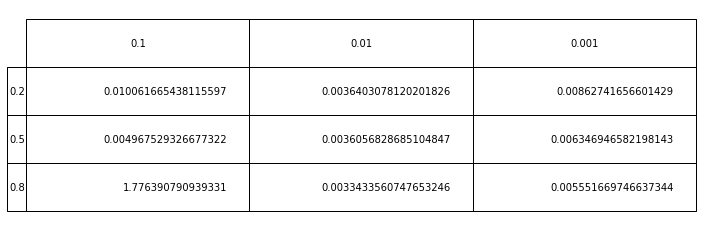

In [ ]:
fig, ax =plt.subplots(1,1)

column_labels=["0.1", "0.01", "0.001"]
row_labels = ["0.2", "0.5", "0.8"]
ax.axis('tight')
ax.axis('off')
tab = ax.table(cellText=losses,colLabels=column_labels,rowLabels=row_labels,loc="center")
tab.scale(2,4)

print("Grid Search table for loss (momentums/learning-rate): ")
plt.show()

Grid Search table for accuracy (momentums/learning-rate): 


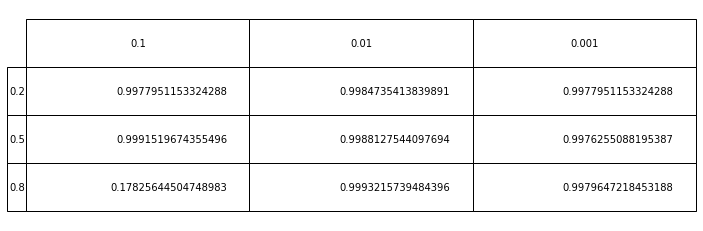

In [ ]:
fig, ax =plt.subplots(1,1)

column_labels=["0.1", "0.01", "0.001"]
row_labels = ["0.2", "0.5", "0.8"]
ax.axis('tight')
ax.axis('off')
tab = ax.table(cellText=accuracies,colLabels=column_labels,rowLabels=row_labels,loc="center")
tab.scale(2,4)

print("Grid Search table for accuracy (momentums/learning-rate): ")
plt.show()

When learning_rate=0.1, momentum=0.8, the training result is bad. This means 0.1 is a too large learning rate which cause the data cannot converge.

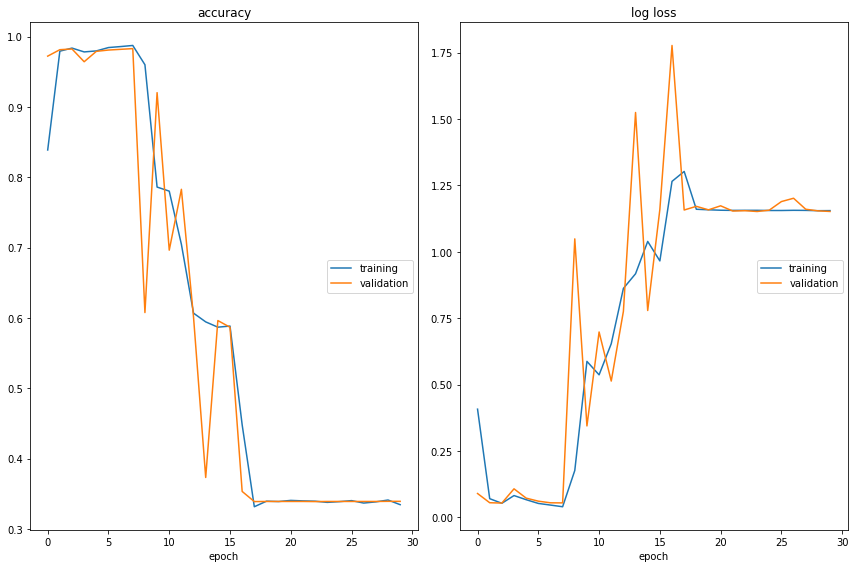

accuracy
	training         	 (min:    0.332, max:    0.987, cur:    0.335)
	validation       	 (min:    0.339, max:    0.983, cur:    0.339)
log loss
	training         	 (min:    0.040, max:    1.303, cur:    1.155)
	validation       	 (min:    0.054, max:    1.777, cur:    1.152)


In [ ]:
model, _ , _ = train_model(0.8, 1e-1, visualize=True)

From the results shown in the table, the most appropriate value of the learing rate is 0.01 which have less losses and larger accuracy.

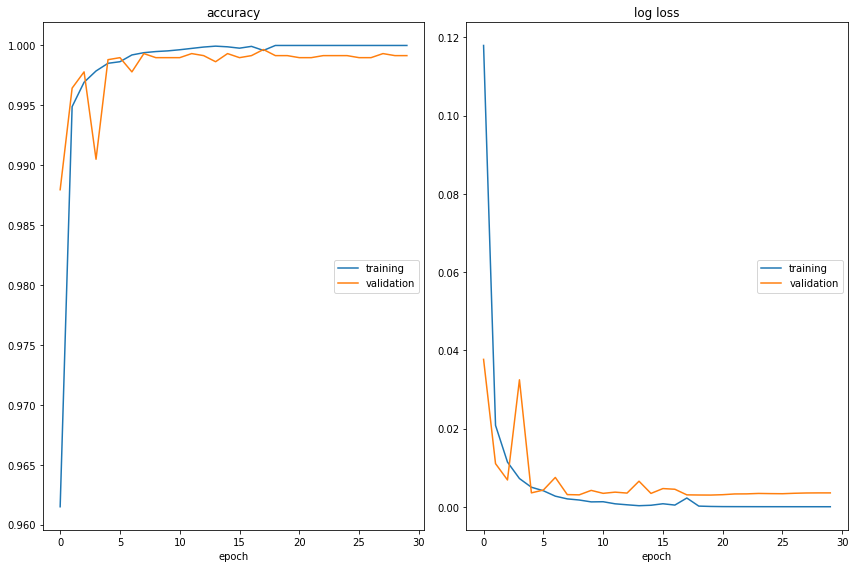

accuracy
	training         	 (min:    0.961, max:    1.000, cur:    1.000)
	validation       	 (min:    0.988, max:    1.000, cur:    0.999)
log loss
	training         	 (min:    0.000, max:    0.118, cur:    0.000)
	validation       	 (min:    0.003, max:    0.038, cur:    0.004)


In [ ]:
model, _ , _ = train_model(0.8, 1e-2, visualize=True)

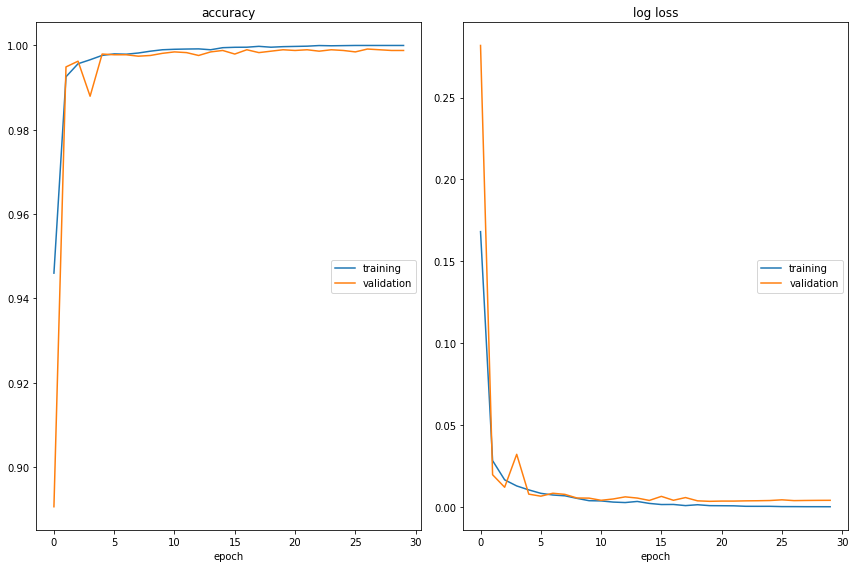

accuracy
	training         	 (min:    0.946, max:    1.000, cur:    1.000)
	validation       	 (min:    0.891, max:    0.999, cur:    0.999)
log loss
	training         	 (min:    0.000, max:    0.168, cur:    0.000)
	validation       	 (min:    0.003, max:    0.282, cur:    0.004)


In [ ]:
model, _ , _ = train_model(0.5, 1e-2, visualize=True)

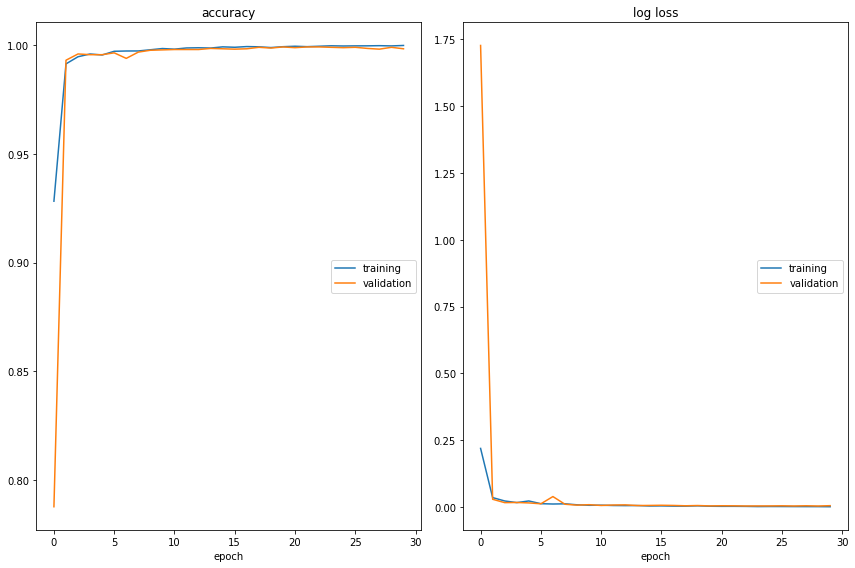

accuracy
	training         	 (min:    0.928, max:    1.000, cur:    1.000)
	validation       	 (min:    0.788, max:    0.999, cur:    0.998)
log loss
	training         	 (min:    0.001, max:    0.219, cur:    0.001)
	validation       	 (min:    0.003, max:    1.727, cur:    0.005)


In [ ]:
model, _ , _ = train_model(0.2, 1e-2, visualize=True)

By observing the figures shown above, the most appropriate value of momentum is 0.5. The training and validation data have small fluctuations and the accuarcies are close to 1, the losses are close to 0.
Therefore, the selected parameters are momentum=0.5, learning rate=1e-2.

## 6-Train with best hyperparameters [5 points]

Once you have your two best hyperparameters, retrain the model by combining your split datasets **as you see fit** and explain why you chose this particular combination. Report the final accuracy on the test set. Use *livelossplot* to plot the values of the training evolution and explain changes in performance with your new combination of datasets.

## The Answer is:

Split the data using `sklearn.model_selection.StratifiedShuffleSplit` with new combination:

- 80\% of the data in the training set
- 20\% of the data in the test set

The training set should be the most part of the whole dataset, and test set aims to test the training results.

Retrain the model with the parameters momentum=0.5 and learning rate=0.01 which have been selected in the last section.

In [45]:
# split the data
# set test_size=0.1 for 80:20 ratio of training and test dataset
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(ds, labels) # create a shuffler
indices = [(train_idx, test_idx) for train_idx, test_idx in shuffler][0] # extract indices

X_train, y_train = apply_standardization(ds[indices[0]].float()), labels[indices[0]]
X_val, y_val = apply_standardization(ds[indices[1]].float()), labels[indices[1]]

medical_mnist_train = TensorDataset(X_train, y_train.long())
medical_mnist_test = TensorDataset(X_val, y_val.long())

# pass datasets to DataLoaders
train_loaders = DataLoader(medical_mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loaders = DataLoader(medical_mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

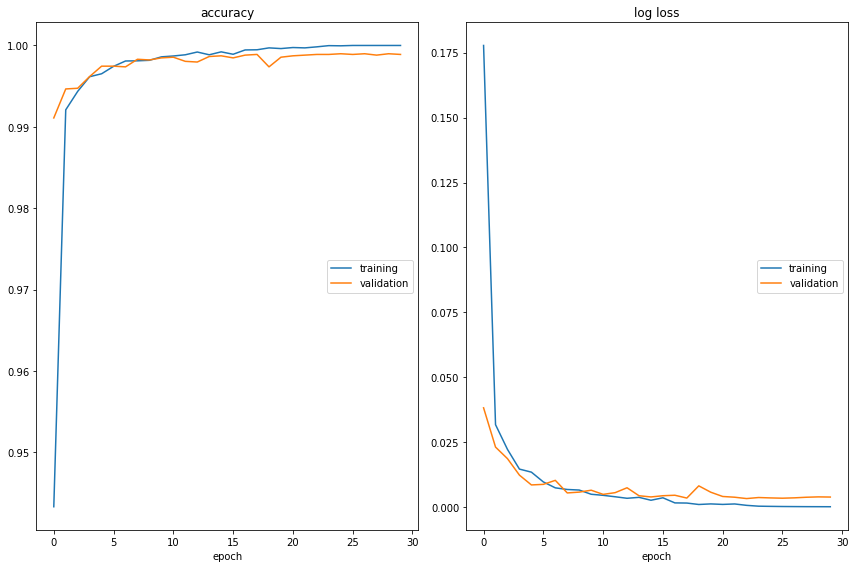

accuracy
	training         	 (min:    0.943, max:    1.000, cur:    1.000)
	validation       	 (min:    0.991, max:    0.999, cur:    0.999)
log loss
	training         	 (min:    0.000, max:    0.178, cur:    0.000)
	validation       	 (min:    0.003, max:    0.038, cur:    0.004)


In [46]:
best_momentum=0.5
best_lr=1e-2

best_model, _, _  = train_model(momentum=best_momentum, lr=best_lr, visualize=True)

It is a good training model when I use the parameters I selected in the last section.

In [47]:
# define CrossEntropy as the criterion function used
criterion = nn.CrossEntropyLoss()
# print the test_loss and test_accuracy
test_loss, test_accuracy = validate(best_model, criterion, validation_loaders)    
print("Test Loss: %1.3f" % test_loss.item(), "Test Accuracy: %1.3f" % test_accuracy.item())

Test Loss: 0.004 Test Accuracy: 0.999


There are not much changes of average values of losses and accuracies compared with last section(ratio of 9:1), but the minumum values become larger. The slight fluctuations in the curve have increased. With larger amount of test datasets, the minimum accuarcy should be increased and losses be decreased. The final average results mainly depending on the parameters we selected, so the average values did not change.

## 7-Comparison with original LeNet implementation  [10 points]}
Read the paper *Gradient based learning applied to document recognition* provided. What are the main differences between their implementation and the one you are using in this coursework?

[**You only need to read and understand the paper until section** III. RESULTS AND COMPARISON WITH OTHER METHODS, *B. Results*, **included, which finishes on page 11 (you can ignore the rest)**]



## The Answer is:

There are several differences between the original LeNet network and the one I am using in the coursework.

*   **The pooling layers.** I use the maxpool method which selects the maxmium input of the four in one unit, but in the paper, the four inputs are added, multiplied by a trainable coefficient and added to a trainable bias.
*   **Input sizes.** The input images' sizes are 64x64, but the paper uses 32x32 images as inputs.
*   **Output sizes.** In this coursework, the images are classified into 6 classes, while the paper with 10.
*   **Output layer connection method.** The output layer I used is fully connected to last F6. According to the paper, Gaussian connections have been implemented in the network. The output layer it implemented is composed of Euclidean Radial Basis Function units.
*   **Activation method.** I select ReLU function as the activation method in the model. In the paper, the sigmoidal function has been used.
*   **Loss function.** I simply applied cross-entropy as loss function which iss equal to (minus) the log-likelihood of a Bernouilli distribution. In the paper, the network used with the Maximum Likelihood Estimation criterion(MLE) which is equivalent to the Minimum Mean Squared Error(MSE).







## 8-Number of parameters in LeNet-5 [5 points]

Calculate how many trainable parameters the LeNet network you have implemented for this coursework has, and compare it to the number of parameters of the original LeNet network described in the paper you read in the previous question. Explain how you calculate the number of parameters for both cases.

[**answers that only contain the number of parameters without justification will be awarded 0 points**]

## The Answer is:

The total number of parameters to train for the layer can be calculate by the equation:


> ***Number of filters x (size of filter + 1 bias term)***

According to the equation, we can calcualte the number of trainable parameters for each network's layer.

According to size I mentioned in the section 3. The LeNet network implemented in the coursework:

Layer C1: (5x5x1+1)x6 = 156 trainable parameters.

Layer C3: (5x5x6+1)x16 = 2416 trainable parameters.

Layer C5: (13x13x16+1)x120 = 324600 trainable parameters.

Layer F6: 120x84+84 = 10164 trainable parameters.

Output Layer: 84x6+x6 = 510 trainable parameters.

The total trainable parameters are 337846. There are no trainable parameters in pooling layers (layer S2 and layer S4).

------------------------------------
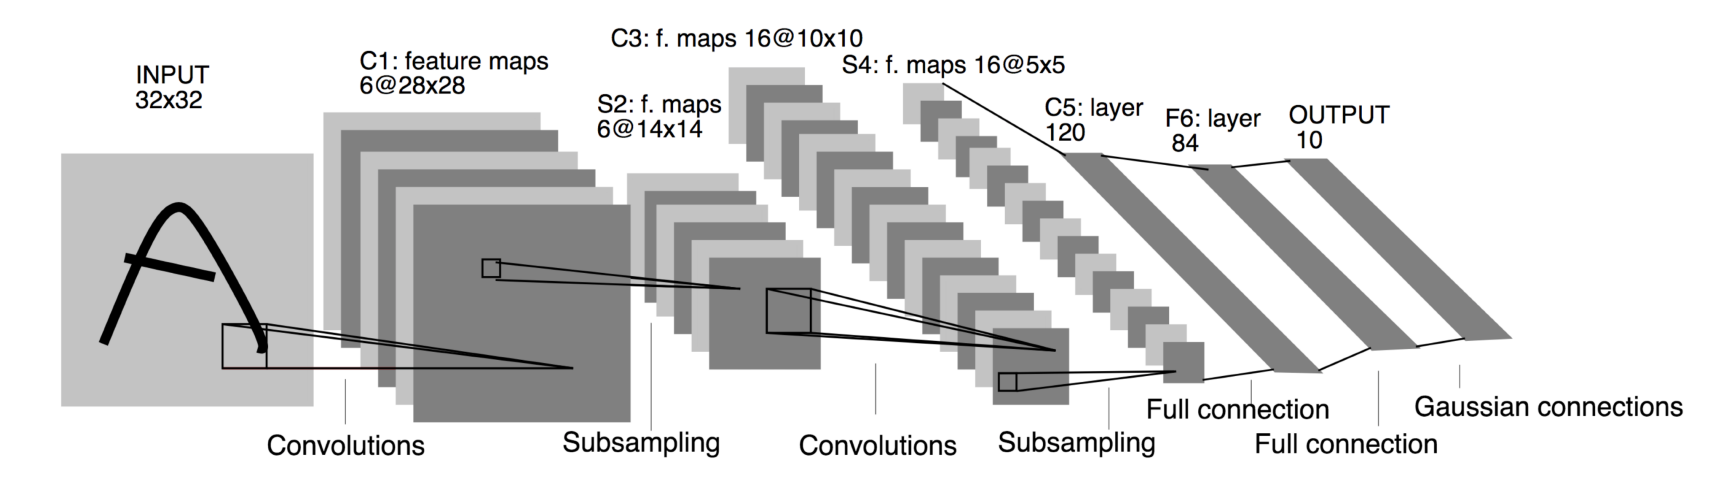

Original LeNet network:

Layer C1: (5x5x1+1)x6 = 156 trainable parameters.

Layer S2: 12 trainable parameters.

Layer C3: (5x5x3+1)x6+(5x5x4+1)x6+(5x5x4+1)x3+(5x5x6+1)x1 = 1516 trainable parameters. It uses subset of S2's feature maps to connect.

Layer S4: 32 trainable parameters.

Layer C5: (5x5x16+1)x120 = 48120 trainable parameters.

Layer F6: 120x84+84 = 10164 trainable parameters.

Output Layer: 84x10 = 840 trainable parameters with no bias term.

The total trainable parameters are 60840.

The differences of trainable parameters between original LeNet network and the LeNet network I have implemented for this coursework are reflected in layer C3 and layer C5 and the pooling layers.

Our trainable parameters are much larger than original LeNet network. The  training results can be more accurate but it is easily for overfitting because of too much trainable parameters.

## 9-Visualising loss landscapes paper - 1 [10 points]

Read the provided paper *Visualising the Loss Landscape of Neural Nets*. This paper contains a lot of advanced concepts, but you only need to read and understand it well up to and including section 4 (Proposed Visualisation: Filter-Wise Normalisation) to answer the questions below. In section 4 you don't need to fully understand the rationale for doing Filter-Wise Normalisation, but you do need to understand what Filter-Wise Normalisation is.

Answer the following question (in a markdown cell):
- What are the dimensions of the parameters $\delta$, $\eta$, $\alpha$ and $\beta$ in equation (1) using your LeNet network? [5 points]
- Describe what is the role of each of these parameters [5 points]

Explain in detail and justify your answers.

## The Answer is:

Q1:

According to the equation 1 in the paper, $$f(\alpha, β) = L(θ^{*} + \alpha \delta + \beta\eta)$$.

$\alpha$ and $\beta$ are two scalar parameters which are in 1-Dimensional.

$\delta$ and $\eta$ are two direction vectors, according to the equation, we can know that the they are in the same dimension of $θ^{*}$, which is the training parameters of the model. Therefore, the dimension of $\delta$ and $\eta$ are 337846.

Q2:

$\alpha$ and $\beta$ are the corresponding strides of $\delta$ and $\eta$ which determines the weights average. $\delta$ and $\eta$ are the random direction vectors from the center point $θ^{*}$(optimal solution). They form 2D plane. Every different values of $θ^{*} + \alpha \delta + \beta\eta$ form a new $θ$, which can be used to calculate its corresponding loss. $\delta$ and $\eta$ can be considered as two basis vectors of the 2D plane. They are used to plot the 2D loss landscape.

## 10-Visualise loss landscapes - 2 [20 points]

Use the formula described in equation (1) in the paper in combination with the Filter-Wise Normalisation to generate landscape plots in these two cases:
- your final trained model (output of question *6*).
- your randomly initialised model.

In both cases, use 25 values for $\alpha$ and 25 values for $\beta$ to generate a 2D plot with 625 points.

Use the provided snippets of code in the Jupyter Notebook template to assist you in generating the plots and to guide you in the functions you will need to implement.

Analyse, compare and discuss your plots. How are they different? and why? Justify the choices you make along the generation process of plotting the loss landscapes (for example, but not limited to, the range your choose for your $\alpha$ and $\beta$ values).

[**you can use a subset of the data to generate the plots, but explain what effect this will have in the results**]

In [29]:
# The following snippets of code are only to assist you. You can decide to use 
# them or not. They are only intended to provide you with some functionality
#  you may find useful when trying to generate the loss landscape plots.


# function to create random directions:
def create_random_directions(weights, ignore1D=False, seed=42):
    torch.manual_seed(seed)
    direction = [torch.randn(w.size()).to(device) for w in weights]
    
    # apply filter normalisation, where every perturbation d in direction has the same norm as its corresponding w in weights
    for d, w in zip(direction, weights):
        if ignore1D and d.dim() <= 1:
            d.fill_(0)
        d.mul_(w.norm()/(d.norm() + 1e-10)) # add small perturbation to avoid division by zero

    return direction


# function to update weigths
def update_weights(model, origin_weights, x_dir, y_dir, dx=0.1, dy=0.1):
    updates = [x.to(device)*dx + y.to(device)*dy for (x, y) in zip(x_dir, y_dir)]
    for (p, w, u) in zip(model.parameters(), origin_weights, updates):
        p.data = w + u
    return None


# function to plot loss landscape as a surface
def plot_loss_landscape(xx, yy, loss_landscape):
    fig, ax = plt.subplots(figsize=(8, 8),subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(xx, yy, loss_landscape, cmap='viridis', edgecolor='none',
                       linewidth=0, antialiased=True,  rstride=1, cstride=1,)
    ax.set_xlabel(r'X')
    ax.set_ylabel(r'Y')
    ax.set_zlabel(r'Loss')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


# function to plot loss landscape as a contour
def contour_loss_landscape(xx, yy, loss_landscape):
    fig, ax = plt.subplots(figsize=(7, 7))
    surf = ax.contourf(xx, yy, loss_landscape, cmap='viridis', levels=100)
    ax.set_xlabel(r'X')
    ax.set_ylabel(r'Y')
    fig.colorbar(surf, shrink=0.5, aspect=5)

    # Mark the minima
    minima_coordinates, minima_f = np.unravel_index(np.argmin(loss_landscape),loss_landscape.shape), np.min(loss_landscape)
    ax.plot(xx[minima_coordinates], yy[minima_coordinates],'b*')
    plt.show()


# BONUS: functions to compute the angle between 2 random vectors
# in high-dimensional spaces two random vectors are quite likely to be
# orthogonal (or almost). No points involved here, this is just for fun!
#
def angle(vec1, vec2):
    return torch.acos(torch.dot(vec1, vec2)/(vec1.norm()*vec2.norm())).item()

def rad2deg(angle):
    return angle*180/np.pi

def concat_torch_list(torch_list):
    for i, t in enumerate(torch_list):
        torch_list[i] = t.flatten()
    return torch.cat(torch_list)

First, recall the best model selected in section 6.

In [54]:
best_momentum=0.5
best_lr=1e-2

best_model, _, _  = train_model(momentum=best_momentum, lr=best_lr, visualize=False)

Copy the best model which is important because we need to use the updated model to calculate the new weights. Then create two random direction vectors $\delta$ and $\eta$ for updating weights.

In [55]:
# deep copy the model for updating weights
# best_model with the best hyperparameters: momentum=0.5, learning_rate=0.01
best_model_copy = deepcopy(best_model)

# Create two random direction vectors
# the seed of the two direction generators should not be the same
delta = create_random_directions(best_model_copy.parameters(), ignore1D=False, seed=31)
eta = create_random_directions(best_model_copy.parameters(), ignore1D=False, seed=42)

We can compute the angle between two vectors. We can find that these two vectors are almost perpendicular, which means they can be considered as basis vectors in 2-D plane.

In [49]:
print(r"The angle between two vectors is (in degrees): {0:.2f}".format(rad2deg(angle(concat_torch_list(delta), concat_torch_list(eta)))))

The angle between two vectors is (in degrees): 89.77


We need use 25 values for $\alpha$ and 25 values for $\beta$ to generate a 2D plot with 625 points. I define the range of $α$ and $β$ as [-0.007, 0.007].

In [56]:
criterion = nn.CrossEntropyLoss()

# Define a 2D meshgrid 
alpha = np.linspace(-0.007, 0.007, 25)
beta = np.linspace(-0.007, 0.007, 25)
xx, yy = np.meshgrid(alpha, beta)
loss_landscape = np.zeros((25, 25))
for i in range(25):
  for j in range(25):
    dx = xx[i][j]
    dy = yy[i][j]
    # Calculate loss for each grid
    # Note that we should use the origin model's parameters to update weights
    update_weights(best_model_copy, best_model.parameters(), delta, eta, dx, dy)
    loss_landscape[i, j] = validate(best_model_copy, criterion, validation_loaders)[0].item()

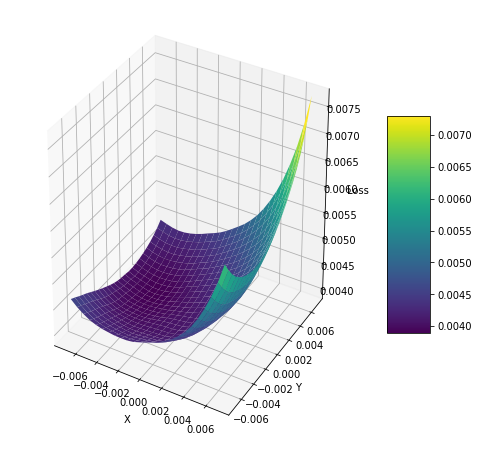

In [57]:
plot_loss_landscape(xx, yy, loss_landscape)

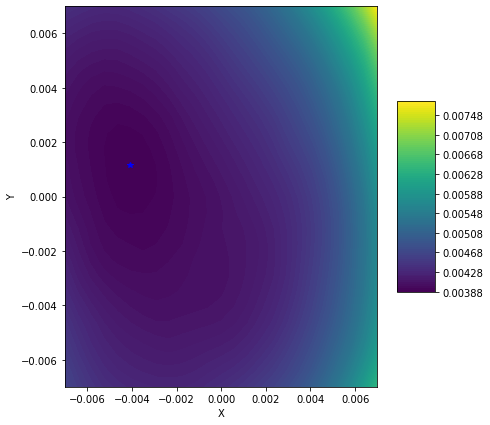

In [58]:
contour_loss_landscape(xx, yy, loss_landscape)

We can observe that the minimum point is not on the center point $θ^{*}$: (0, 0), which means it is not the global minimum point, so it is not the real optimal result. The hyperparameters I selected should be changed. The error is small.

If the learning rate is large, when close to the minimum value, the step size of each iteration may be too large, then it is easily to exceed the actual optimal solution and cause errors, but the learning rate should be larger when it is far from the minimum value to increase efficiency. The ideal learning rate should be a dynamically changing value.

Randomly intialize a model used LeNet5 network we difined in section 3. Repeat the above steps.

In [59]:
# Random initialise a LeNet5 model
random_model = LeNet5()
random_model.to(device)
random_model_copy = deepcopy(random_model)
delta = create_random_directions(random_model_copy.parameters(), ignore1D=False, seed=31)
eta = create_random_directions(random_model_copy.parameters(), ignore1D=False, seed=42)
alpha = np.linspace(-0.01, 0.01, 25)
beta = np.linspace(-0.01, 0.01, 25)
xx, yy = np.meshgrid(alpha, beta)
loss_landscape = np.zeros((25, 25))
for i in range(25):
  for j in range(25):
    dx = xx[i][j]
    dy = yy[i][j]
    # Calculate loss for each grid
    update_weights(random_model_copy, random_model.parameters(), delta, eta, dx, dy)
    loss_landscape[i, j] = validate(random_model_copy, criterion, validation_loaders)[0].item()

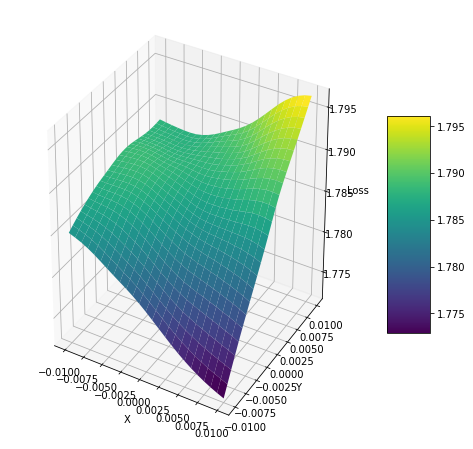

In [60]:
plot_loss_landscape(xx, yy, loss_landscape)

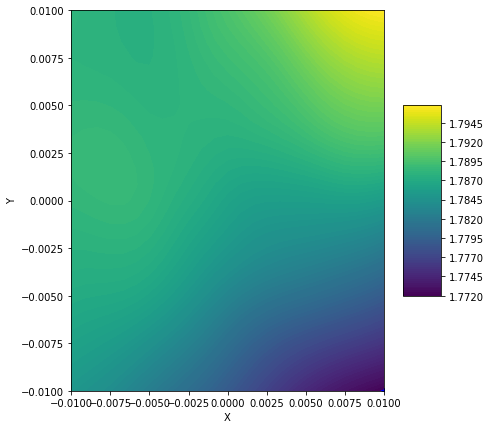

In [61]:
contour_loss_landscape(xx, yy, loss_landscape)

According to the figure above, the minimal point of random model does not show in the range [-0.01, 0.01], which means it is not the global optimal solution, and the error is huge.

From the final figures of the above two cases, we can know that after training, we can find the approximate optimal solution. However, the training model I find in section 6 still not the optimal combination of the hyberparameters. 

For the design of the meshgrid($α$ and $β$), the denser the grid is defined, the denser the contours, so that we can get more precise minima.